## PCA-GMM Clustering ##

<b>20/09/2024</b>

PCA Clustering, by draw,gives a high degree of seperation - about 12.4%, which may pssibly be sufficient for an NN to 'latch onto' and train differentially.

NZ Lotteries commission do not specify which Halogen 2 machine is in-use per-draw, so this is one method which can be used to evaluate which is which. The function is on a draw-by-draw basis, which is consistent with the mechnanism in use.

This code has been modified to _only_ consider Balls 1 to 6 for PCA Clustering. Although Ball 7 (The Powerball) data is available, it 

Output of this application are a pair of xlsx spreadsheets, 'Machine 0' and 'Machine 1'.

Preprocess data like this to isolate one machine from another also opens for additional analysis, using different NN Architectures. Whether there is a pattern is not possible to confirm at any time.

Libraries:

Pandas, Numpy, Sklearn, Matplotlib, Seaborn.

In [1]:
#Init Block#
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Load Data
def load_data(filepath):
    data = pd.read_csv(filepath)
    return data

# Step 2: Handle Missing Values
def handle_missing_data(data):
    imputer = SimpleImputer(strategy='mean')  # Impute missing values with mean
    data_imputed = imputer.fit_transform(data)
    return pd.DataFrame(data_imputed, columns=data.columns)

# Step 3: Feature Scaling
def scale_features(data):
    scaler = StandardScaler()  # Standardize features by removing the mean and scaling to unit variance
    scaled_data = scaler.fit_transform(data)
    return scaled_data

# Step 4: Calculate Frequency Trends for Balls 1 to 40 (Balls 1 to 6)
def calculate_frequency_trends(data, window_size=50):
    num_balls_main = 40  # Balls 1 to 40 for main draw
    freq_trends_1_to_40 = pd.DataFrame(0, index=data.index, columns=np.arange(1, num_balls_main + 1))

    for i in range(window_size, len(data) + 1):
        main_draw_data = data.iloc[i - window_size:i, 1:7].values.flatten()  # Use Balls 1 to 6 only
        main_draw_data = np.round(main_draw_data).astype(int)  # Convert to integers

        # Get bincount for the main draw balls, ensuring the result has length 40
        main_ball_counts = np.bincount(main_draw_data, minlength=num_balls_main + 1)[1:]  # Ignore zero index
        if len(main_ball_counts) == 40:
            freq_trends_1_to_40.loc[i - 1] = main_ball_counts

    freq_trends_1_to_40 = freq_trends_1_to_40.fillna(0)
    return freq_trends_1_to_40

# Step 5: Apply PCA
def apply_pca(data, variance_threshold=0.95):
    pca = PCA(n_components=None)
    pca.fit(data)
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    num_components = np.argmax(explained_variance_ratio >= variance_threshold) + 1
    print(f"Selected {num_components} components to retain {variance_threshold * 100}% of variance.")

    pca = PCA(n_components=num_components)
    data_reduced = pca.fit_transform(data)
    return data_reduced, pca

# Step 6: Optimize GMM Clustering with Silhouette Score
def optimize_gmm_with_silhouette(data_reduced, max_clusters=5):
    best_gmm = None
    best_clusters = 2
    best_silhouette = -1

    for n in range(2, max_clusters+1):
        gmm = GaussianMixture(n_components=n, random_state=0, covariance_type='full')
        clusters = gmm.fit_predict(data_reduced)

        silhouette = silhouette_score(data_reduced, clusters)
        print(f'Clusters: {n}, Silhouette Score: {silhouette:.4f}')

        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_gmm = gmm
            best_clusters = n

    print(f"Selected {best_clusters} clusters with the highest Silhouette Score: {best_silhouette}")
    return best_gmm, best_clusters

# Step 7: Visualize Clustering Result
def visualize_clustering(data_reduced, clusters, pca):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=data_reduced[:, 0], y=data_reduced[:, 1], hue=clusters, palette='coolwarm', s=60)
    plt.title('PCA Visualization of Optimized GMM Clustering')
    plt.xlabel(f'PCA Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PCA Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 8: Output Clusters to Excel (including Draw, Balls 1 to 6, and Ball_7)
def output_clusters_with_draw_number(data, clusters, output_prefix='Machine'):
    # Select Draw number and Balls 1 to 6 + Ball_7 (Powerball)
    draw_and_ball_data = data.iloc[:, :8]  # Draw number + Balls 1 to 6 + Ball_7 (Powerball)
    
    # Convert clusters list to NumPy array for boolean indexing
    clusters = np.array(clusters)

    # Separate data into two clusters (Machine 0 and Machine 1)
    machine_0 = draw_and_ball_data[clusters == 0]
    machine_1 = draw_and_ball_data[clusters == 1]

    # Output to Excel files, now including the Draw number and Ball_7 (Powerball)
    machine_0.to_excel(f'{output_prefix}_0.xlsx', index=False)
    machine_1.to_excel(f'{output_prefix}_1.xlsx', index=False)

    print(f"Output files generated: {output_prefix}_0.xlsx and {output_prefix}_1.xlsx (including Draw, Balls 1 to 6, and Ball_7)")


Selected 22 components to retain 95.0% of variance.


E:\Anaconda3\envs\Pytorch39\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
E:\Anaconda3\envs\Pytorch39\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Clusters: 2, Silhouette Score: 0.5928
Clusters: 3, Silhouette Score: 0.1848
Clusters: 4, Silhouette Score: 0.2097


E:\Anaconda3\envs\Pytorch39\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
E:\Anaconda3\envs\Pytorch39\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Clusters: 5, Silhouette Score: 0.2263
Selected 2 clusters with the highest Silhouette Score: 0.5928264581960458


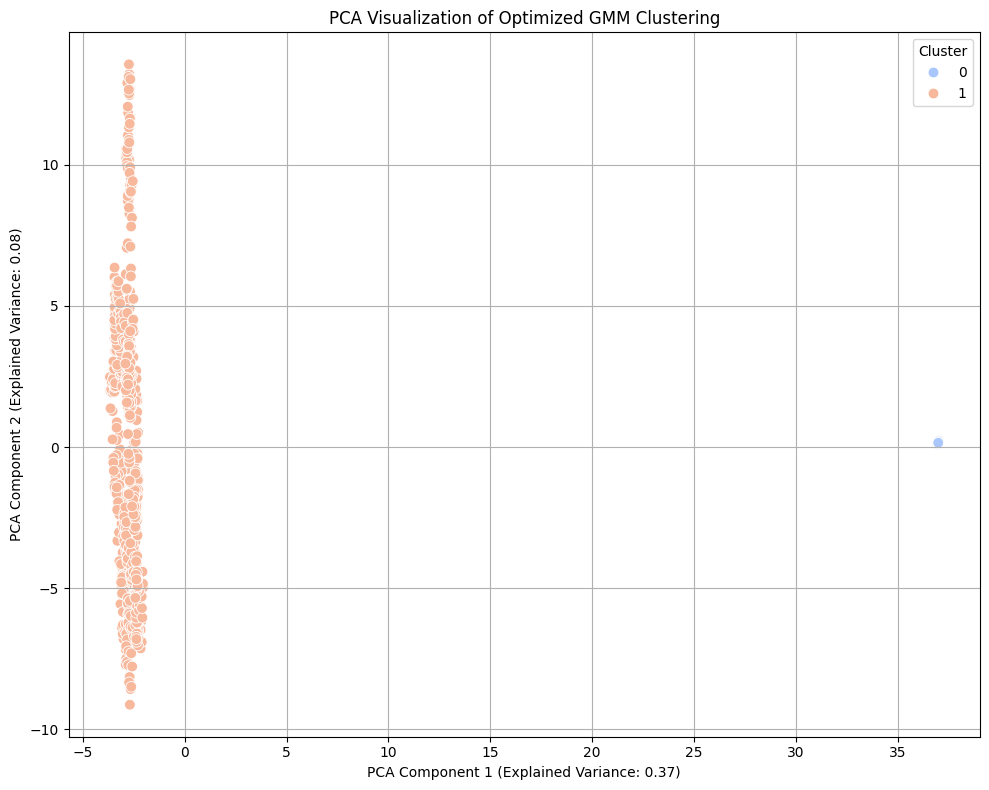

Output files generated: Machine_0.xlsx and Machine_1.xlsx (including Draw, Balls 1 to 6, and Ball_7)


In [3]:
# Main Execution
if __name__ == "__main__":
    # Filepath to the dataset
    filepath = 'lotto_history.csv'
    
    # Step 1: Load data
    data = load_data(filepath)
    
    # Step 2: Handle missing data
    data_cleaned = handle_missing_data(data)
    
    # Step 3: Extract draw order features (Balls 1 to 6, excluding Ball_7)
    draw_order_data = data_cleaned.iloc[:, 1:7]
    
    # Step 4: Calculate frequency trends over a sliding window (e.g., last 50 draws)
    freq_trends_1_to_40 = calculate_frequency_trends(draw_order_data, window_size=50)
    
    # Step 5: Combine the draw order data with frequency trends for clustering
    combined_data = np.hstack([scale_features(draw_order_data), freq_trends_1_to_40.values])
    
    # Step 6: Apply PCA
    data_reduced, pca = apply_pca(combined_data, variance_threshold=0.95)
    
    # Step 7: Optimize and apply GMM clustering using silhouette score
    best_gmm, best_clusters = optimize_gmm_with_silhouette(data_reduced, max_clusters=5)
    clusters = best_gmm.predict(data_reduced)
    
    # Step 8: Visualize the clustering result
    visualize_clustering(data_reduced, clusters, pca)
    
    # Step 9: Output clustered data to Excel files for Machine 0 and Machine 1 (including Draw)
    output_clusters_with_draw_number(data, clusters)